# Training of a fingerspelling recognition model

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import sklearn
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter

import snntorch as snn
from snntorch import surrogate

from snn_training_helper_functions import *


print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version (PyTorch build):", torch.version.cuda)
print("torch:", torch.__version__)
print("mps built:", torch.backends.mps.is_built())
print("mps available:", torch.backends.mps.is_available())

#### Define: Sign dataset class - 24 letters

In [ ]:
class SignDataset:
    def __init__(self, root,  H=28, W=28, max_t=None, transform = None):
        self.LETTERS = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
        self.label_map =   {'A': 0,
                            'B': 1,
                            'C': 2,
                            'D': 3,
                            'E': 4,
                            'F': 5,
                            'G': 6,
                            'H': 7,
                            'I': 8,
                            'K': 9,
                            'L': 10,
                            'M': 11,
                            'N': 12,
                            'O': 13,
                            'P': 14,
                            'Q': 15,
                            'R': 16,
                            'S': 17,
                            'T': 18,
                            'U': 19,
                            'V': 20,
                            'W': 21,
                            'X': 22,
                            'Y': 23}
        self.H = H
        self.W = W
        self.D = H * W
        self.max_t = max_t  
        self.transform = transform
        self.samples = []
        for f in os.listdir(root): # go through data samples
            if not (f.endswith(".npy") or f.endswith(".npz")):
                continue
            label_char = f[0].upper()
            if label_char not in self.label_map:
                continue
            path = os.path.join(root, f)
            self.samples.append((path, self.label_map[label_char]))

    def __len__(self):
        return len(self.samples)

    def _load_events(self, path):
        # .npy structured array case
        ev = np.load(path, allow_pickle=False)
        return ev

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        
        if path.endswith(".npy"):
            t, nid = load_spike_tuples(path)  
        elif path.endswith(".npz"):
            t, nid = load_spike_tuples_npz(path)

        t = t - t.min()  
        t = np.floor(t).astype(np.int64) 

        if self.max_t is not None:
            T = int(self.max_t)
            t = np.clip(t, 0, T - 1)
        else:
            T = int(t.max()) + 1

        m = (nid >= 0) & (nid < self.D)
        t = t[m]
        nid = nid[m]

        X = torch.zeros((T, self.D), dtype=torch.float32)
        if t.size:
            X[t, nid] = 1.0
        return X, int(label)


#### Define: Model

In [ ]:
spike_grad = surrogate.fast_sigmoid(slope=25)

class TinyConvSNN_24_FC(nn.Module):
    def __init__(self, H=48, W=48, n_classes=24, beta=0.95, num_steps=100, dropout_p=0.0, fc_hidden=512):
        super().__init__()
        self.H, self.W = H, W
        self.n_classes = n_classes
        self.num_steps = num_steps
        
        # Conv layer (L1)
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, stride=6, padding=0, bias=False)
        
        # Hidden layer (L2)
        self.fc1 = nn.Linear(256, fc_hidden, bias=False)  
        self.lif_fc1 = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_beta=False)  
        self.dropout_fc1 = nn.Dropout(p=dropout_p)  
        
        # Readout layer (L3)
        self.readout = nn.Linear(fc_hidden, n_classes, bias=False)  
        
        # LIF neurons
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_beta=False)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, learn_beta=False)
        
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.dropout_readout = nn.Dropout(p=dropout_p)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_normal_(m.weight, gain=1.0)
    
    def forward(self, x):
        T, B, _ = x.shape
        x = x.view(T, B, 1, self.H, self.W)
        
        mem1 = self.lif1.init_leaky().to(x.device)
        mem_fc1 = self.lif_fc1.init_leaky().to(x.device)  
        memo = self.lif_out.init_leaky().to(x.device)
        
        spk_out_rec = []
        for t in range(T):
            xt = x[t]
            # Conv layer
            cur1 = self.conv1(xt)
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1 = self.dropout1(spk1)
            # Flatten
            feat = spk1.flatten(1)  # [B, 256]
            # Hidden FC layer 
            cur_fc1 = self.fc1(feat)
            spk_fc1, mem_fc1 = self.lif_fc1(cur_fc1, mem_fc1)
            spk_fc1 = self.dropout_fc1(spk_fc1)
            # Readout layer
            spk_fc1_drop = self.dropout_readout(spk_fc1)
            cur_out = self.readout(spk_fc1_drop)
            spk_out, memo = self.lif_out(cur_out, memo)
            
            spk_out_rec.append(spk_out)
        
        return torch.stack(spk_out_rec, dim=0)
    
    @torch.no_grad()
    def predict(self, x):
        # x: [T,B,2304]
        spk = self.forward(x)
        counts = spk.sum(0)              # [B,26]
        return counts.argmax(dim=1)

In [ ]:
class EarlyStopping:
    """
    Early stopping + best-checkpoint saving.
    """
    def __init__(self, monitor="val_acc", patience=10, min_delta=0.0,
                 ckpt_path="best_model.pt", verbose=True):
        assert monitor in ("val_acc", "val_loss")
        self.monitor = monitor
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.ckpt_path = ckpt_path
        self.verbose = verbose

        self.best = None
        self.best_epoch = -1
        self.num_bad_epochs = 0

    def _is_improvement(self, value: float) -> bool:
        if self.best is None:
            return True
        if self.monitor == "val_acc":
            return value > (self.best + self.min_delta)
        else:  # val_loss
            return value < (self.best - self.min_delta)

    def step(self, value: float, epoch: int, model, optimizer=None, scheduler=None, extra: dict | None = None) -> bool:
        """
        Returns True if training should stop.
        """
        value = float(value)
        if self._is_improvement(value):
            self.best = value
            self.best_epoch = epoch
            self.num_bad_epochs = 0

            ckpt = {
                "epoch": epoch,
                "monitor": self.monitor,
                "best_value": self.best,
                "model_state_dict": model.state_dict(),
            }
            if optimizer is not None:
                ckpt["optimizer_state_dict"] = optimizer.state_dict()
            if scheduler is not None:
                ckpt["scheduler_state_dict"] = scheduler.state_dict()
            if extra is not None:
                ckpt["extra"] = extra

            os.makedirs(os.path.dirname(self.ckpt_path) or ".", exist_ok=True)
            torch.save(ckpt, self.ckpt_path)

            if self.verbose:
                print(f"[EarlyStopping] New best {self.monitor}={self.best:.6f} at epoch {epoch}. Saved -> {self.ckpt_path}")
            return False

        self.num_bad_epochs += 1
        if self.verbose:
            print(f"[EarlyStopping] No improvement in {self.monitor}. bad_epochs={self.num_bad_epochs}/{self.patience}")

        return self.num_bad_epochs >= self.patience

    def restore_best(self, model, device=None):
        ckpt = torch.load(self.ckpt_path, map_location=device if device is not None else "cpu")
        model.load_state_dict(ckpt["model_state_dict"])
        return ckpt

# Load data

In [ ]:
input_spatial_size = 48 # size of input in pixels
num_steps = 35 # matching to 35 ms windows
batch_size = 64

trainval_root = "data/ASL_DVS/test_ROI_spikes_35ms" 
trainval_dataset = SignDataset(trainval_root, H=input_spatial_size, W=input_spatial_size, max_t = num_steps, transform=None)

indices = np.arange(len(trainval_dataset))
train_idx, val_idx = sklearn.model_selection.train_test_split(indices, test_size = 0.2, random_state = 42, shuffle = True)
train_dataset = Subset(trainval_dataset, train_idx)
val_dataset = Subset(trainval_dataset, val_idx)

test_root = "data/ASL_DVS/test_ROI_spikes_35ms"
test_dataset = SignDataset(test_root, H=input_spatial_size, W=input_spatial_size, max_t = num_steps, transform = None)


train_loader = DataLoader(train_dataset, batch_size=batch_size , shuffle=True,
                          collate_fn= collate_timefirst)
val_loader = DataLoader(val_dataset, batch_size=batch_size , shuffle=False,
                          collate_fn=collate_timefirst)
test_loader  = DataLoader(test_dataset, batch_size=batch_size , shuffle=False,
                          collate_fn=collate_timefirst)

In [ ]:
class_weights, class_counts = analyze_class_distribution(train_dataset)
print(f"\nClass weights: {class_weights}")

# Create dataloaders
train_loader = create_balanced_dataloader(train_dataset, batch_size=batch_size )


Class distribution:
A:  902 ( 5.01%)
B:  900 ( 5.00%)
C:  718 ( 3.99%)
D:  720 ( 4.00%)
E:  713 ( 3.96%)
F:  727 ( 4.04%)
G:  886 ( 4.92%)
H:  724 ( 4.02%)
I:  728 ( 4.04%)
K:  705 ( 3.92%)
L:  900 ( 5.00%)
M:  732 ( 4.07%)
N:  718 ( 3.99%)
O:  721 ( 4.01%)
P:  691 ( 3.84%)
Q:  729 ( 4.05%)
R:  720 ( 4.00%)
S:  710 ( 3.94%)
T:  726 ( 4.03%)
U:  717 ( 3.98%)
V:  727 ( 4.04%)
W:  734 ( 4.08%)
X:  728 ( 4.04%)
Y:  724 ( 4.02%)

Class weights: tensor([0.8315, 0.8333, 1.0446, 1.0417, 1.0519, 1.0316, 0.8465, 1.0359, 1.0302,
        1.0638, 0.8333, 1.0246, 1.0446, 1.0402, 1.0854, 1.0288, 1.0417, 1.0563,
        1.0331, 1.0460, 1.0316, 1.0218, 1.0302, 1.0359])


#### Visualize single sample

torch.Size([35, 2304]) 9


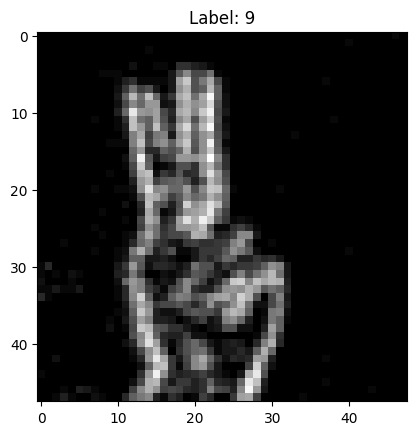

In [ ]:
x, y = train_dataset[13]
img = x.sum(0).reshape(input_spatial_size, input_spatial_size)
plt.imshow(img, cmap='gray')
plt.title(f"Label: {y}")
plt.show()

## Set up the training

In [ ]:
def train_snn(model, train_loader, val_loader=None, num_epochs=5, num_steps=25, 
              loss_fn=None, optimizer=None, scheduler=None, writer = None, device="cpu", 
              print_every=1, n_letters = 24, log_every_steps = 50,
              early_stop=True,
              es_monitor="val_acc",     # or "val_loss"
              es_patience=10,
              es_min_delta=0.0,
              best_ckpt_path="checkpoints/best_model.pt",
              restore_best=True):
    """
    Returns:
        train_losses: list of avg training loss per epoch
        val_losses  : list of avg validation loss per epoch
        val_accs    : list of validation accuracies per epoch 
    """
    
    model.to(device)
    early_stopper = None
    if early_stop and (val_loader is not None):
        early_stopper = EarlyStopping(
            monitor=es_monitor,
            patience=es_patience,
            min_delta=es_min_delta,
            ckpt_path=best_ckpt_path,
            verbose=True
        )

    train_losses = []
    train_accs = []
    val_losses = [] if val_loader is not None else None
    val_accs = [] if val_loader is not None else None
    global_step = 0

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch}/{num_epochs}")
        model.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        train_out_mean_sum = 0.0
        train_out_max = 0.0
        train_batches = 0

        pbar = tqdm(train_loader, desc="Training")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            if imgs.dim() == 3 and imgs.size(0) != num_steps:
                imgs = imgs.transpose(0, 1)
            
            if labels.ndim > 1:
                labels = labels.argmax(dim=1)

            assert labels.dtype == torch.long
            assert labels.min() >= 0

            optimizer.zero_grad()

            spk_out = model(imgs)              # [T,B,C]
            spk_sum = spk_out.sum(0)           # [B,C]
            logits = spk_sum[:, :n_letters]    # active classes

            #focal loss
            probs = torch.softmax(logits, dim=1)
            loss = loss_fn(probs, labels)
            loss.backward()
            optimizer.step()

            # train metrics
            train_loss_sum += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # activity stats (output)
            out_mean = logits.mean().item()
            out_max = logits.max().item()
            train_out_mean_sum += out_mean
            train_out_max = max(train_out_max, out_max)
            train_batches += 1

            # gradient norm (train-only)
            grad_norm_sq = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    g = p.grad.data
                    grad_norm_sq += g.norm(2).item() ** 2
            grad_norm = grad_norm_sq ** 0.5

            # step-level logging (throttled)
            if (global_step % log_every_steps) == 0:
                writer.add_scalar("loss/train_step", loss.item(), global_step)
                writer.add_scalar("acc/train_step", (preds == labels).float().mean().item(), global_step)

                # log learning rate if present
                if optimizer is not None and len(optimizer.param_groups) > 0:
                    writer.add_scalar("opt/lr_step", optimizer.param_groups[0]["lr"], global_step)
                writer.flush()

            global_step += 1
            pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*train_correct/train_total:.2f}%'
        })

        # epoch-level train logging
        avg_train_loss = train_loss_sum / max(1, len(train_loader))
        train_acc = 100.0 * train_correct / max(1, train_total)

        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)
        writer.add_scalar("loss/train_epoch", avg_train_loss, epoch)
        writer.add_scalar("acc/train_epoch", train_acc, epoch)
        writer.add_scalar("spikes_train/out_mean_epoch", train_out_mean_sum / max(1, train_batches), epoch)
        writer.add_scalar("spikes_train/out_max_epoch", train_out_max, epoch)
        writer.flush()

        # weight norms (epoch-level, train-only)
        with torch.no_grad():
            for name, p in model.named_parameters():
                if p.ndim >= 2:  # skip biases; log main tensors
                    writer.add_scalar(f"weights_l2/{name}", p.data.norm().item(), epoch)

        # validation
        if val_loader is not None:
            model.eval()
            val_loss_sum = 0.0
            val_correct = 0
            val_total = 0

            val_out_mean_sum = 0.0
            val_out_max = 0.0
            val_batches = 0

            with torch.no_grad():
                pbar = tqdm(val_loader, desc="Evaluating")
                for imgs, labels in pbar:
                    imgs, labels = imgs.to(device), labels.to(device)
                    if labels.ndim > 1:
                        labels = labels.argmax(dim=1)

                    spk_out = model(imgs)
                    logits = spk_out.sum(0)[:, :n_letters]

                    if logits.shape[1] != n_letters:
                        raise ValueError(f"Val logits have {logits.shape[1]} classes, expected {n_letters}")
                    if labels.max().item() >= n_letters or labels.min().item() < 0:
                        raise ValueError(
                            f"Val labels out of range: min={labels.min().item()} "
                            f"max={labels.max().item()} n_letters={n_letters}"
                        )

                    #focal loss
                    probs = torch.softmax(logits, dim=1)
                    loss = loss_fn(probs, labels)

                    # loss = loss_fn(logits, labels) # crossentropy loss
                    val_loss_sum += loss.item()

                    preds = logits.argmax(dim=1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)

                    out_mean = logits.mean().item()
                    out_max = logits.max().item()
                    val_out_mean_sum += out_mean
                    val_out_max = max(val_out_max, out_max)
                    val_batches += 1

                    pbar.set_postfix({
                        "loss": f"{loss.item():.4f}",
                        "acc": f"{100.0*val_correct/val_total:.2f}%"
                    })

            avg_val_loss = val_loss_sum / max(1, len(val_loader))
            val_acc = 100.0 * val_correct / max(1, val_total)

            val_losses.append(avg_val_loss)
            val_accs.append(val_acc)

            writer.add_scalar("loss/val_epoch", avg_val_loss, epoch)
            writer.add_scalar("acc/val_epoch", val_acc, epoch)
            writer.add_scalar("spikes_val/out_mean_epoch", val_out_mean_sum / max(1, val_batches), epoch)
            writer.add_scalar("spikes_val/out_max_epoch", val_out_max, epoch)
            writer.flush()
            
        # ---------- EARLY STOPPING ----------
        if early_stopper is not None:
            metric_value = val_acc if es_monitor == "val_acc" else avg_val_loss
            stop = early_stopper.step(
                metric_value, epoch,
                model=model,
                optimizer=optimizer,
                scheduler=scheduler,
                extra={"avg_val_loss": avg_val_loss, "val_acc": val_acc}
            )
            if stop:
                print(f"[EarlyStopping] Stopping at epoch {epoch}. Best at epoch {early_stopper.best_epoch} with {es_monitor}={early_stopper.best:.6f}")
                break
        # ----------------------------------------

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)  # Needs metric
            else:
                scheduler.step()  # CosineAnnealingWarmRestarts, OneCycleLR, etc.
            
            writer.add_scalar("opt/lr_epoch", optimizer.param_groups[0]["lr"], epoch)
            
        if (epoch + 1) % 5 == 0:
            class_names = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
            cm = confusion_matrix_snn(
                model, val_loader,
                device=device,
                n_letters=len(class_names)
            )

            clear_output(wait=True)   
            fig = plot_cm_inline(
                cm,
                class_names,
                normalize=True,
                title=f"Val confusion matrix (epoch {epoch+1})"
            )
            display(fig)
            plt.close(fig)

            # Plot train/val accuracy curves
            fig_acc, ax = plt.subplots(figsize=(10, 6))
            
            epochs_so_far = list(range(len(train_accs)))

            # Plot training accuracy
            ax.plot(epochs_so_far, train_accs, 'b-', label='Train Accuracy', linewidth=2, marker='o', markersize=3)
            
            # Plot validation accuracy
            if val_accs:
                ax.plot(epochs_so_far, val_accs, 'r-', label='Val Accuracy', linewidth=2, marker='s', markersize=3)
            
            ax.set_xlabel('Epoch', fontsize=12)
            ax.set_ylabel('Accuracy (%)', fontsize=12)
            ax.set_title(f'Training Progress (Epoch {epoch+1}/{num_epochs})', fontsize=14, fontweight='bold')
            ax.legend(fontsize=11, loc='lower right')
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0, 100])
            
            # Add current values as text
            current_train_acc = train_accs[-1]
            current_val_acc = val_accs[-1] if val_accs else 0
            gap = current_train_acc - current_val_acc
            
            ax.text(0.02, 0.98, 
                    f'Epoch {epoch+1}: Train={current_train_acc:.2f}% | Val={current_val_acc:.2f}% | Gap={gap:.2f}%',
                    transform=ax.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                    fontsize=10,
                    fontweight='bold')
            
            plt.tight_layout()
            display(fig_acc)
            plt.close(fig_acc)
        
    writer.close()
    return train_losses, val_losses, val_accs

In [ ]:
def create_model(config, device):
    model = TinyConvSNN_24_FC(
        H=48, W=48,
        n_classes=24,
        beta=config['beta'],
        num_steps=config['num_steps'],
        dropout_p=config['dropout_p'],
        fc_hidden=config['fc_hidden']
    ).to(device)
    
    def init_weights(m):
        if isinstance(m, nn.Conv2d):
            # Kaiming initialization for conv 
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.Linear):
            # Xavier for linear layers
            nn.init.xavier_normal_(m.weight, gain=1.0)
    
    model.apply(init_weights)
    return model

## Run TRAINING

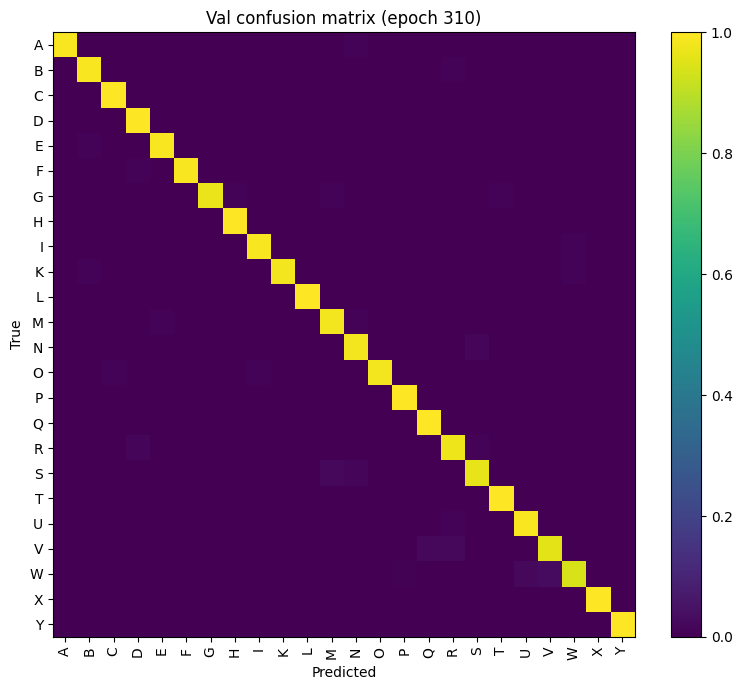

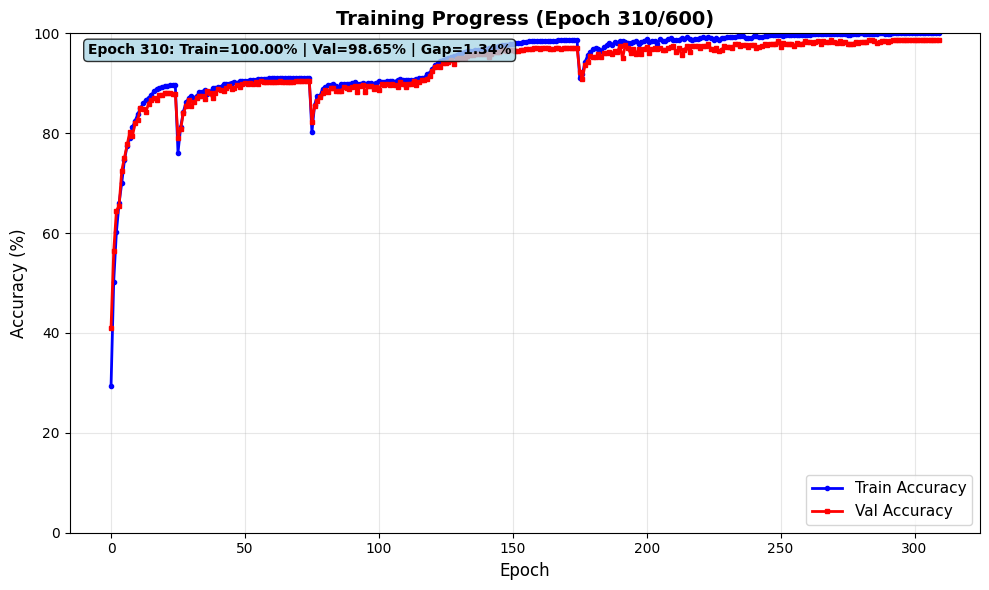

Epoch: 310/600


Evaluating: 100%|██████████| 113/113 [00:17<00:00,  6.56it/s, loss=12.0543, acc=83.84%]


[EarlyStopping] No improvement in val_acc. bad_epochs=14/250
Epoch: 311/600


Evaluating: 100%|██████████| 113/113 [00:15<00:00,  7.17it/s, loss=12.0123, acc=83.87%]


[EarlyStopping] No improvement in val_acc. bad_epochs=15/250
Epoch: 312/600


Evaluating: 100%|██████████| 113/113 [00:19<00:00,  5.79it/s, loss=12.0143, acc=83.88%]


[EarlyStopping] No improvement in val_acc. bad_epochs=16/250
Epoch: 313/600


Evaluating: 100%|██████████| 113/113 [00:18<00:00,  6.02it/s, loss=12.0167, acc=83.92%]


[EarlyStopping] No improvement in val_acc. bad_epochs=17/250
Epoch: 314/600


Training:  40%|███▉      | 153/387 [00:32<00:50,  4.66it/s, loss=3.8022, acc=100.00%]


KeyboardInterrupt: 

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

n_letters = 24
beta = 0.92 
fc_hidden = 512 
num_steps = 35

model_snn =  create_model({
    'beta': beta,  # Faster dynamics for 95ms windows
    'fc_hidden': fc_hidden,
    'dropout_p': 0.0,  # No dropout - we use other regularization
    'num_steps': num_steps,  # After removing 5ms peak
}, device)

loss_fn = EnhancedFocalLoss(gamma=2.0,
                            alpha=class_weights.to(device),
                            label_smoothing=0.1,
                            mining_threshold=0.65,)

optimizer = torch.optim.AdamW(
    model_snn.parameters(),
    lr=3e-3,              # Moderate starting LR
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=25,
    T_mult=2,
    eta_min=2e-7
)

run_ID = "tiny_conv_up_08_FC_2" # name for tensorboard logs and checkpoints

os.makedirs("checkpoints", exist_ok=True)
writer = SummaryWriter(log_dir=f"runs/{run_ID}")
save_model_checkpoints = f"checkpoints/{run_ID}.pt"

train_losses, val_losses, val_accs = train_snn(
    model=model_snn,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=300,
    num_steps=num_steps,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler = scheduler,
    writer = writer,
    device=device,
    n_letters = n_letters,
    early_stop=True,
    es_monitor="val_acc",
    es_patience=30,
    es_min_delta=0.0,  
    best_ckpt_path= save_model_checkpoints,
    restore_best=True
)

## Load model from checkpoint (.pt) and evaluate

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

model =  TinyConvSNN_24_FC(
    H=48, W=48,
    n_classes=24,
    beta=0.92, 
    num_steps=35,
    dropout_p=0.0, 
    fc_hidden=512
).to(device)

ckpt = torch.load("checkpoints/checkpointpath.pt", map_location=device)
model.load_state_dict(ckpt["model_state_dict"], strict=True)
model.eval()

#------ Load data ------
test_root = "data/ASL_DVS/test_5_ROI_spikes_35ms"
input_spatial_size = 48
test_dataset = SignDataset(test_root, H=input_spatial_size, W=input_spatial_size, transform = None)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True,
                          collate_fn=collate_timefirst)

#------ Evaluate ------
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        
        preds = model.predict(x)  
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

#------ Accuracy and conf. matrix ------
overall_acc = (all_preds == all_labels).mean()
print("Overall accuracy:", float(overall_acc))


kept_labels = np.arange(0,24) #24 letters
cm = confusion_matrix(all_labels, all_preds, labels=kept_labels)
print(cm)

# Per-class accuracy
row_sums = cm.sum(axis=1)
per_class_acc = np.divide(cm.diagonal(), np.maximum(row_sums, 1))

worst_classes = np.argsort(per_class_acc)[:5]
print("Worst 5 letters:", [chr(65 + i) for i in worst_classes])
print("Worst 5 accuracies:", [float(per_class_acc[i]) for i in worst_classes])

# Most confused pairs (true != pred)
cm_norm = cm / np.maximum(row_sums[:, None], 1)
cm_norm_no_diag = cm_norm.copy()
np.fill_diagonal(cm_norm_no_diag, 0.0)

k = 10
flat = np.argsort(cm_norm_no_diag.ravel())[-k:][::-1]
pairs = [np.unravel_index(i, cm_norm_no_diag.shape) for i in flat]

print("Top confusions:")
for t, p in pairs:
    rate = cm_norm_no_diag[t, p]
    count = cm[t, p]
    if count > 0:
        print(f"{chr(65+t)} -> {chr(65+p)} : rate={rate:.3f}  count={count}")

for i in range(24):
    print(f"{chr(65+i)}: acc={per_class_acc[i]:.3f}  support={row_sums[i]}")



device: mps
Overall accuracy: 0.9227083333333334
[[195   0   0   0   0   0   0   0   0   1   1   0   0   0   0   0   0   0
    1   0   0   1   0   1]
 [  1 190   0   0   1   1   0   0   0   0   0   0   0   1   0   0   1   0
    0   3   0   1   1   0]
 [  7   0 182   0   3   1   2   2   2   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  3   0   0 189   0   0   0   0   1   0   1   0   0   0   0   0   6   0
    0   0   0   0   0   0]
 [  0   0   0   0 194   0   0   0   0   0   1   0   1   0   0   2   0   0
    0   0   0   2   0   0]
 [  6   1   0   1   0 190   0   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  2   0   0   0   2   0 196   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 197   0   0   0   0   0   0   0   3   0   0
    0   0   0   0   0   0]
 [ 49   7   2  19   4   5   5   0  44   7  18   1   1   2   1   2  13   1
    2   5   0   0  12   0]
 [  0   0   0   0   0   0   0   0   0 199 